## Load Libraries

In [1]:
import os
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt

from glob import glob
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
%matplotlib inline

## Load Images

### List all Folder

In [2]:
image_folders = glob('Dataset/*/')
image_folders

['Dataset\\Apple\\',
 'Dataset\\Grape\\',
 'Dataset\\Lemon\\',
 'Dataset\\Limes\\',
 'Dataset\\Lychee\\',
 'Dataset\\Pear\\']

### List all images in each folder

In [3]:
folder_path = image_folders[0]
folder_name = folder_path.split("\\")[1]
all_image_in_folder = glob(folder_path + "*.jpg")

### List Single Image

In [4]:
img_path = all_image_in_folder[0]
label = folder_name

### Load Single Image

In [5]:
img = cv2.imread(img_path)

### Use OpenCV To Read Image

In [6]:
img = cv2.imread(img_path)

### Remove White Background (Threshold)

In [7]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

### Display Image

In [8]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

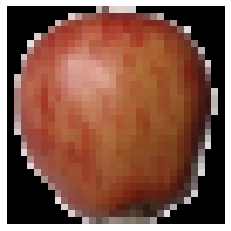

In [9]:
img = cv2.imread(img_path)
img = cv2.resize(img, (32, 32),interpolation = cv2.INTER_AREA)
img = remove_background(img, 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("F.jpg", img)
display(img)

### Display Plot Image Grid

In [10]:
def plot_img_grid(img_arr, nb_rows, nb_cols, figsize=(5, 5)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].imshow(img_arr[n], interpolation = 'nearest')
            axs[i, j].axis('off')
            n += 1  

### Reshape Image

In [11]:
img_arr = np.array(img)
img_flatten = img_arr.reshape(1, -1).T

### Squeeze Array

In [12]:
img_squeeze = np.squeeze(img_flatten)

## Image Preprocessing

### Normal Image

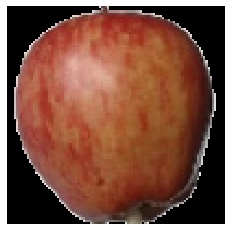

In [13]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display(img)

### Convert Image to Gray Image

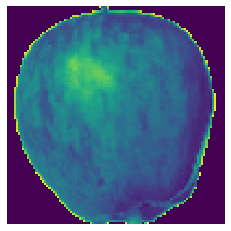

In [14]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(img_gray)

### Apply Gaussian Blur

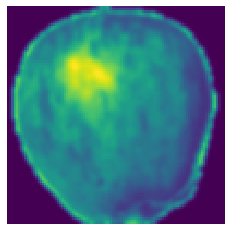

In [15]:
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
display(img_blur)

### Draw Edges (Canny Edge)

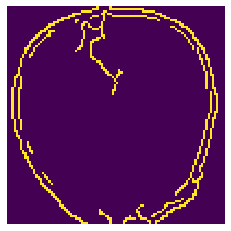

In [16]:
img_canny = cv2.Canny(img_blur, 50, 150)
display(img_canny)

### Edge Dilation

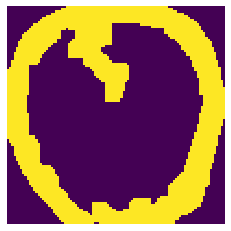

In [17]:
kernel = np.ones((7, 7), dtype = np.uint8)
img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
display(img_dilate)

### Crop Image from Edge

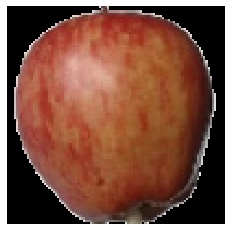

In [18]:
contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roi = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    roi = img[y: y + h, x: x + w]
    
display(roi)

### Mask Crop Image

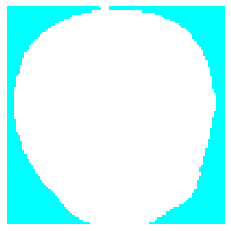

In [19]:
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

im_floodfill = roi.copy()

h, w = roi.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
cv2.floodFill(im_floodfill, mask, (90,90), 255);

# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Combine the two images to get the foreground.
im_out = roi | im_floodfill_inv
display(im_out)

### Apply Contrast to Image

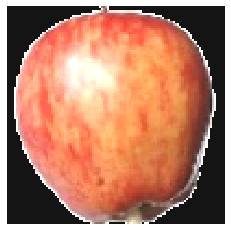

In [20]:
img_contrast = cv2.convertScaleAbs(img, alpha=1.5, beta=20)
display(img_contrast)

## Color Enhancement

### Color Normalization

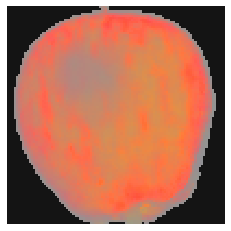

In [21]:
# Convert Image from uint8 to float32
img_float = img / 255.0

# Color Enhancement
r, g, b = cv2.split(img_float)
img_sum = r + g + b
CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)

tmp_img = cv2.merge((CR, CG, CB))
tmp_img = np.uint8(tmp_img * 255)
tmp_img = cv2.convertScaleAbs(tmp_img, alpha=1.5, beta=20)
display(tmp_img)

### Short Demo

In [22]:
tmp_img_path = "Test_Images\\Apple\\apple4.jpg"

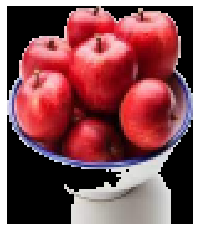

In [23]:
tmp_img = cv2.imread(tmp_img_path)
tmp_img = cv2.resize(tmp_img, (100, 100),interpolation = cv2.INTER_AREA)
tmp_img = remove_background(tmp_img, 225)
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
display(tmp_img)

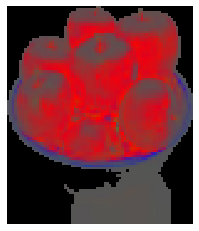

In [24]:
# Convert Image from uint8 to float32
tmp_img_float = tmp_img / 255.0

 # Color Enhancement - Enhance the R, G, B Colors of the image
r, g, b = cv2.split(tmp_img_float)
tmp_img_sum = r + g + b
CR, CG, CB = cv2.divide(r, tmp_img_sum), cv2.divide(g, tmp_img_sum), cv2.divide(b, tmp_img_sum)
tmp_img_tmp = cv2.merge((CR, CG, CB))

# Convert the image from float32 to uint8
tmp_img_tmp = np.uint8(tmp_img_tmp * 255)
display(tmp_img_tmp)

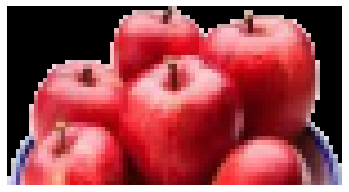

In [25]:
# Convert the image to Gray Image
tmp_img_gray = cv2.cvtColor(tmp_img_tmp, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to Image
tmp_img_blur = cv2.GaussianBlur(tmp_img_gray, (7,7), 1)

# Canny Edge Detection
tmp_img_canny = cv2.Canny(tmp_img_blur, 50, 150)

# Edge Detector
kernel = np.ones((5, 5), dtype = np.uint8)
tmp_img_dilate = cv2.dilate(tmp_img_canny, kernel, iterations = 1)

contours, hier = cv2.findContours(tmp_img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

roi = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    roi = tmp_img[y: y + h, x: x + w]
    
display(roi)

## Color Features

### Convert Value

In [26]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 64:
        return "00"
    elif x >= 64 and x < 128:
        return "55"
    elif x >= 128 and x < 192:
        return "AA"
    else:
        return "FF"
    
def convert_val_to_bin(x):
    if x >= 0 and x < 64:
        return 0
    elif x >= 64 and x < 128:
        return 85
    elif x >= 128 and x < 192:
        return 170
    else:
        return 255

In [27]:
img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
# img_squeeze = np.vectorize(convert_val_to_bin)(img_squeeze)

In [28]:
img_2d_arr = img_convert.reshape(-1, 3)

### Convert to List

In [29]:
img_list_arr = img_2d_arr.tolist()

### Convert to String

In [30]:
convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
img_str_arr = [convert_to_str(x) for x in img_list_arr]

### Get Frequency of Unique Values

In [31]:
new_arr = np.array(img_str_arr)
np.unique(new_arr, return_counts=True)

(array(['#000000', '#550000', '#555500', '#555555', '#AA0000', '#AA5500',
        '#AA5555', '#AAAA55', '#AAAAAA', '#FF5555', '#FFAA55', '#FFAAAA',
        '#FFFFAA', '#FFFFFF'], dtype='<U7'),
 array([273, 112,   6,  21,  54, 299, 140,   3,  19,  17,  24,  33,   1,
         22], dtype=int64))

### Convert Image to Dictionary

In [32]:
tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}

## Pipeline Function

In [33]:
def pipeline_1d(img_path, convert_func, threshold = 225, h = 100, w = 100):
    cv_img = cv2.imread(img_path)
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    cv_img = remove_background(cv_img, threshold)
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_func)(img_squeeze)
    return img_convert

In [34]:
def pipeline_1d_img(cv_img, convert_func):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_func)(img_squeeze)
    return img_convert

## Color Features Pipeline

In [35]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

### Use OpenCV To Show Histogram

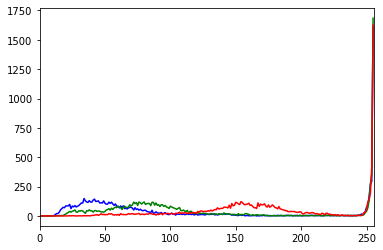

In [36]:
img = cv2.imread(img_path, -1)
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

### Original Image (24-bit Color Palette)

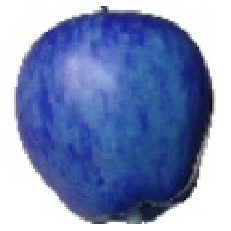

In [37]:
img = cv2.imread(img_path)
display(img)
img = np.array(img)
img = img.reshape(-1, 3)
tmp_df = pd.DataFrame(img, columns = ["r", "g", "b"])

### Original Image Color Histogram

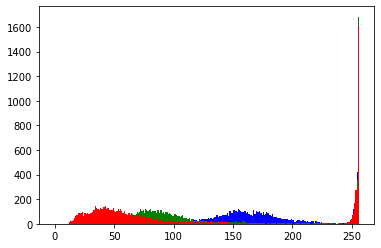

In [38]:
plt.hist(tmp_df["b"],256,[0,256], color="blue")
plt.hist(tmp_df["g"],256,[0,256], color="green")
plt.hist(tmp_df["r"],256,[0,256], color="red")
plt.show()

### New Image (6-bit Color Palette)

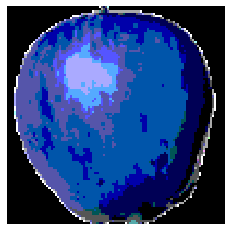

In [39]:
h = w = 100
new_img = pipeline_1d(img_path, convert_val_to_bin, 225, h, w)
new_img = new_img.reshape(h, w, 3)
display(new_img)

### New Image Color Histogram

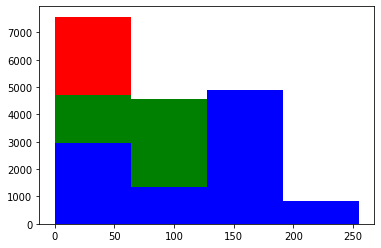

In [40]:
new_img = new_img.reshape(100, 100, 3)
new_img = new_img.reshape(-1, 3)
tmp_df = pd.DataFrame(new_img, columns = ["r", "g", "b"])
plt.hist(tmp_df["r"],color="red", bins=4)
plt.hist(tmp_df["g"],color="green", bins=4)
plt.hist(tmp_df["b"],color="blue", bins=4)
plt.show()

## Show 300 Image (24-bit Color Palette)

### Convert Image Path to OpenCV Image

In [41]:
def convert_img_path_to_cv_img(img_path, threshold = 225, ht = 100, wt = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (wt,ht),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Transform CV Image from unint8 to float32
    img_tmp = cv_img / 255.0
    
    # Color Enhancement - Enhance the R, G, B Colors of the image
    r, g, b = cv2.split(img_tmp)
    img_sum = r + g + b
    CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)
    img_tmp = cv2.merge((CR, CG, CB))
    
    # Convert the image from float32 to uint8
    img_tmp = np.uint8(img_tmp * 255)
    
    # Convert the image to Gray Image
    img_gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    
    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)
    
    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crop the Image
    roi = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = cv_img[y: y + h, x: x + w]
        
    # Darken Image
    roi = cv2.convertScaleAbs(roi, alpha=0.75, beta=20)
    return roi

### Display First 300 Images

In [42]:
def show_300(folder_path, max_num = 300):
    folder_name = folder_path.split("\\")[1]
    all_image_in_folder = glob(folder_path + "*.jpg")
    all_image_in_folder = all_image_in_folder[0:max_num]
    img_arr = [convert_img_path_to_cv_img(img_path) for img_path in all_image_in_folder]
    plot_img_grid(img_arr, 15, 15, (10,10))

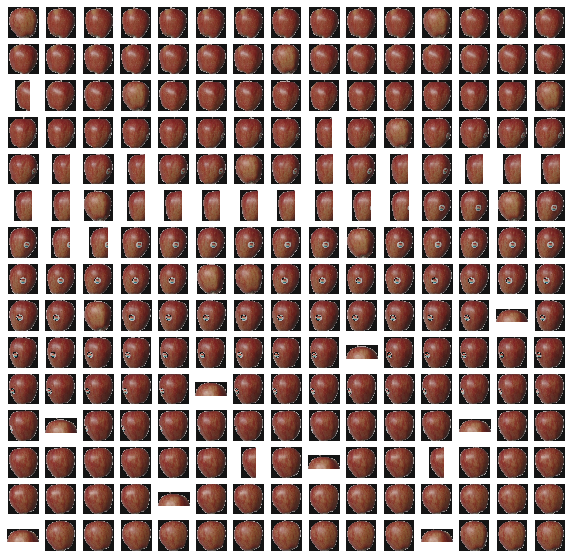

In [43]:
folder_path = 'Dataset\\Apple\\'
show_300(folder_path)

## Texture Features

### Convert New Image to OpenCV Image

In [44]:
cv_img = cv2.imread(img_path)
cv_img = remove_background(cv_img, 225)

### Convert Image to GrayScale Image

In [45]:
img_gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

In [46]:
cv_img = cv2.imread(img_path)
cv_img = remove_background(cv_img, 225)

# Convert Image to Gray Image
img_gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

### Get Mean of Image

In [47]:
mean = np.mean(img_gray)
mean

73.6811

### Get Variance of Image

In [48]:
variance = np.var(img_gray)
variance

2850.7506027899994

### Get Entropy of Image

In [49]:
entropy = skimage.measure.shannon_entropy(img_gray)
entropy

5.987685345121102

### Get Gray Level Occurrence of Image

In [50]:
glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)

### Get Contrast of Image

In [51]:
contrast = greycoprops(glcm, prop="contrast").item()
contrast

1371.741020408163

### Get Homogeneity of Image

In [52]:
homogeneity = greycoprops(glcm, prop="homogeneity").item()
homogeneity

0.3144751929331963

### Get Correlation of Image

In [53]:
correlation = greycoprops(glcm, prop="correlation").item()
correlation

0.754684766980633

### Get Energy of Image

In [54]:
energy = greycoprops(glcm, prop="energy").item()
energy

0.2318352413540574

### Texture Feature Pipeline

In [55]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    
    # Get Mean of image
    tmp_dict["Mean"] = np.mean(img_gray)
    
    # Get Variance of image
    tmp_dict["Variance"] = np.var(img_gray)
    
    # Get Entropy of Image
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    
    # Get Contrast of Image
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    
    # Get Homogeneity of Image
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    
    # Get Correlation of Image
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    
    # Get Energy of Image
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

## Shape Features

In [56]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 2)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    mu, huMoments = [], []
    
    for cnt in contours:
        
        # Get Area of Image from Contour
        area = cv2.contourArea(cnt)
        
        # Get Perimeter of Image From Contour
        peri = cv2.arcLength(cnt, True)
        mu = cv2.moments(cnt)
        
        # Get 7 Humoments From Contour
        huMoments = cv2.HuMoments(mu)
        
    for i in range(0,7):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]) if abs(huMoments[i]) > 0 else 1)
    
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    for (i, huMoment) in enumerate(huMoments):
        tmp_dict[f"huMoment {(i + 1)}"] = huMoment[0]
    return tmp_dict

### Gray Image

In [57]:
cv_img = cv2.imread(img_path)
cv_img = remove_background(cv_img, 225)

# Convert Image to Gray Image
img_gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)

### Get Area of Image

In [58]:
area = pipeline_shape(img_gray)["Area"]
area

8709.5

### Get Perimeter of Image

In [59]:
peri = pipeline_shape(img_gray)["Perimeter"]
peri

350.89444279670715

### Get Moments of Image

In [60]:
tmp = pipeline_shape(img_gray)
huMoments = [tmp[f"huMoment {(i + 1)}"] for i in range(7)]

In [61]:
for (i, huMoment) in enumerate(huMoments):
    print(f"huMoment {(i + 1)} : {huMoment}")

huMoment 1 : 0.7938154005423993
huMoment 2 : 4.521320988085541
huMoment 3 : 4.7154516617373705
huMoment 4 : 7.65340984554721
huMoment 5 : 13.992114180703028
huMoment 6 : -9.915766010853108
huMoment 7 : -13.984660964990477


### Update Final Dictionary

In [62]:
def pipeline_img(img_path, threshold = 225, h = 100, w = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Transform CV Image from unint8 to float32
    img_tmp = cv_img / 255.0
    
    # Color Enhancement - Enhance the R, G, B Colors of the image
    r, g, b = cv2.split(img_tmp)
    img_sum = r + g + b
    CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)
    img_tmp = cv2.merge((CR, CG, CB))
    
    # Convert the image from float32 to uint8
    img_tmp = np.uint8(img_tmp * 255)
    
    # Convert the image to Gray Image
    img_gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    
    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)
    
    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crop the Image
    roi = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = cv_img[y: y + h, x: x + w]
        
    # Darken Image
    roi = cv2.convertScaleAbs(roi, alpha=0.75, beta=20)
    return roi

In [63]:
def pipeline_all_dict(cv_img):
    final_dict = {}
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [64]:
def pipeline_final(img_path):
    cv_img = pipeline_img(img_path)
    final_dict = pipeline_all_dict(cv_img)
    return final_dict

In [65]:
pipeline_final(img_path)

{'#000000': 2784,
 '#550000': 1202,
 '#555500': 718,
 '#555555': 388,
 '#AA0000': 188,
 '#AA5500': 2088,
 '#AA5555': 2072,
 '#AA55AA': 1,
 '#AAAA55': 184,
 '#AAAAAA': 256,
 '#FFAAAA': 19,
 'Mean': 75.80353535353535,
 'Variance': 1588.1029167942047,
 'Entropy': 5.727951426412666,
 'Contrast': 779.7884536082473,
 'Homogeneity': 0.33125308256479497,
 'Correlation': 0.7493151953468238,
 'Energy': 0.22419269796306845,
 'Area': 3034.0,
 'Perimeter': 634.7594473361969,
 'huMoment 1': 0.12324495630906417,
 'huMoment 2': 2.8150584131322565,
 'huMoment 3': 2.850315313489514,
 'huMoment 4': 2.552495025844522,
 'huMoment 5': 5.382519752253782,
 'huMoment 6': 3.971997186154482,
 'huMoment 7': -5.428768553020112}

### Get minimum number of images

In [66]:
num_image_arr = []
for folder_path in glob('Dataset/*/'):
    folder_name = folder_path.split("\\")[1]
    all_images = glob(folder_path + "*.jpg")
    num_image_arr.append(len(all_images))
min_num_of_img = min(num_image_arr)
min_num_of_img

490

### Append To Dataframe

In [67]:
feature_arr = []
cc = ["00", "55", "AA", "FF"]
# cc = ["00", "33", "66", "99", "CC", "FF"]
# cc = ["00", "24", "40", "60", "80", "A0", "C0", "FF"]
for i in cc:
    for j in cc:
        for k in cc:
            feature_arr.append(f"#{i}{j}{k}")
            
feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy"]
feature_arr += [f"huMoment {(i + 1)}" for i in range(7)]
feature_arr += ["Area", "Perimeter"]

In [68]:
final_df = pd.DataFrame(columns = feature_arr)
final_df

Empty DataFrame
Columns: [#000000, #000055, #0000AA, #0000FF, #005500, #005555, #0055AA, #0055FF, #00AA00, #00AA55, #00AAAA, #00AAFF, #00FF00, #00FF55, #00FFAA, #00FFFF, #550000, #550055, #5500AA, #5500FF, #555500, #555555, #5555AA, #5555FF, #55AA00, #55AA55, #55AAAA, #55AAFF, #55FF00, #55FF55, #55FFAA, #55FFFF, #AA0000, #AA0055, #AA00AA, #AA00FF, #AA5500, #AA5555, #AA55AA, #AA55FF, #AAAA00, #AAAA55, #AAAAAA, #AAAAFF, #AAFF00, #AAFF55, #AAFFAA, #AAFFFF, #FF0000, #FF0055, #FF00AA, #FF00FF, #FF5500, #FF5555, #FF55AA, #FF55FF, #FFAA00, #FFAA55, #FFAAAA, #FFAAFF, #FFFF00, #FFFF55, #FFFFAA, #FFFFFF, Mean, Variance, Entropy, Contrast, Homogeneity, Correlation, Energy, huMoment 1, huMoment 2, huMoment 3, huMoment 4, huMoment 5, huMoment 6, huMoment 7, Area, Perimeter]
Index: []

[0 rows x 80 columns]

### Generate CSV (Color, Texture and Shape Features)

In [69]:
# for folder_path in glob('Dataset/*/'):
#     folder_name = folder_path.split("\\")[1]
#     all_images = glob(folder_path + "*.jpg")
#     all_images = all_images[0:min_num_of_img]
#     for img_path in all_images:
#         feature_dict = pipeline_final(img_path)
#         final_df = final_df.append(feature_dict, ignore_index = True)

### Fill in Nan Values

In [70]:
# final_df.fillna(0, inplace=True)

### Add Label

In [71]:
# folder_name_arr = [folder_path.split("\\")[1] for folder_path in glob('Dataset/*/')]
# label_arr = list(itertools.chain.from_iterable(itertools.repeat(x, min_num_of_img) for x in folder_name_arr))

In [72]:
# final_df["Label"] = label_arr

### Shuffle Dataset

In [73]:
# df = final_df

In [74]:
# df = df.sample(frac=1).reset_index(drop=True)

### Output CSV

In [75]:
# df.to_csv("Image_Dataset_Color_Texture_Shape_Features.csv", index = False)